**Next Steps**
- Consider removing features based on correlation matrix (high correlation = collinearity)
- Consider doing Welch t-test (if normal) or Wilcoxon Rank sum (if not normal/skewed) to see diff in means for Fire Start Day group vs. other group. How would this help us?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import math
import warnings
from os.path import join
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow import keras
from keras import metrics
import keras_tuner as kt
from tensorflow.keras import initializers


In [8]:
# # Makes working dir the repo - may be needed if have path issues...
# %cd 207_final_project_Alvaro_Jake_Ruchi_Phillip

In [9]:
# Load data
df = pd.read_csv("./data/CA_Weather_Fire_Dataset_1984-2025.csv")
df.head()

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1984-01-01,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1984-01-02,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1984-01-03,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1984-01-04,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1984-01-05,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


In [11]:
counts = df['LAGGED_PRECIPITATION'].value_counts()
percentages_formatted = df['LAGGED_PRECIPITATION'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

# Concatenate counts and percentages into one DataFrame
result_df = pd.DataFrame({'Count': counts, 'Percentage': percentages_formatted})
print(result_df)

                      Count Percentage
LAGGED_PRECIPITATION                  
0.00                  10049      67.0%
0.01                    198       1.3%
0.02                     97       0.6%
0.02                     73       0.5%
0.04                     69       0.5%
...                     ...        ...
3.00                      1       0.0%
3.75                      1       0.0%
3.53                      1       0.0%
1.80                      1       0.0%
0.03                      1       0.0%

[1001 rows x 2 columns]


In [12]:
df['LAGGED_PRECIPITATION'].value_counts()

LAGGED_PRECIPITATION
0.00    10049
0.01      198
0.02       97
0.02       73
0.04       69
        ...  
3.00        1
3.75        1
3.53        1
1.80        1
0.03        1
Name: count, Length: 1001, dtype: int64

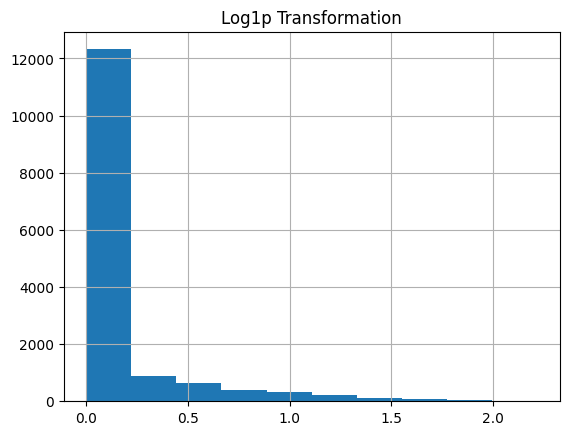

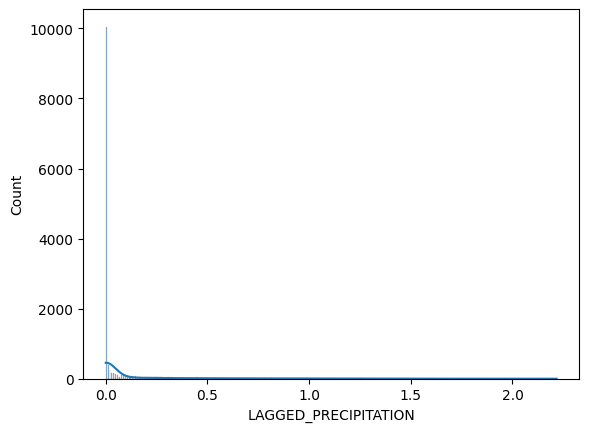

In [13]:
df['LAGGED_PRECIPITATION'].apply(np.log1p).hist()
plt.title("Log1p Transformation")
plt.show()

# Alternatively using Seaborn for better visualization
sns.histplot(np.log1p(df['LAGGED_PRECIPITATION']), kde=True)
plt.show()

In [14]:
# Make column lists

# These cols will likely not inform EDA much. Use this list for easy access
# DATE/YEAR: not helpful in EDA, assuming the underlying climate conditions across years remain relatively constant
# DAY_OF_YEAR: likely same info as Season var
exclude_cols = ['DATE', 'YEAR', 'DAY_OF_YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO']

feature_cols = [c for c in df.columns if c not in exclude_cols]
feature_cols.remove('FIRE_START_DAY')
target_col = 'FIRE_START_DAY'
numeric_cols = feature_cols.copy()
numeric_cols.remove('SEASON')
numeric_cols.remove('MONTH')
cols = feature_cols + [target_col]

print(feature_cols)
print(numeric_cols)

['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'MONTH', 'SEASON', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAYS_WITHOUT_RAIN']
['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAYS_WITHOUT_RAIN']


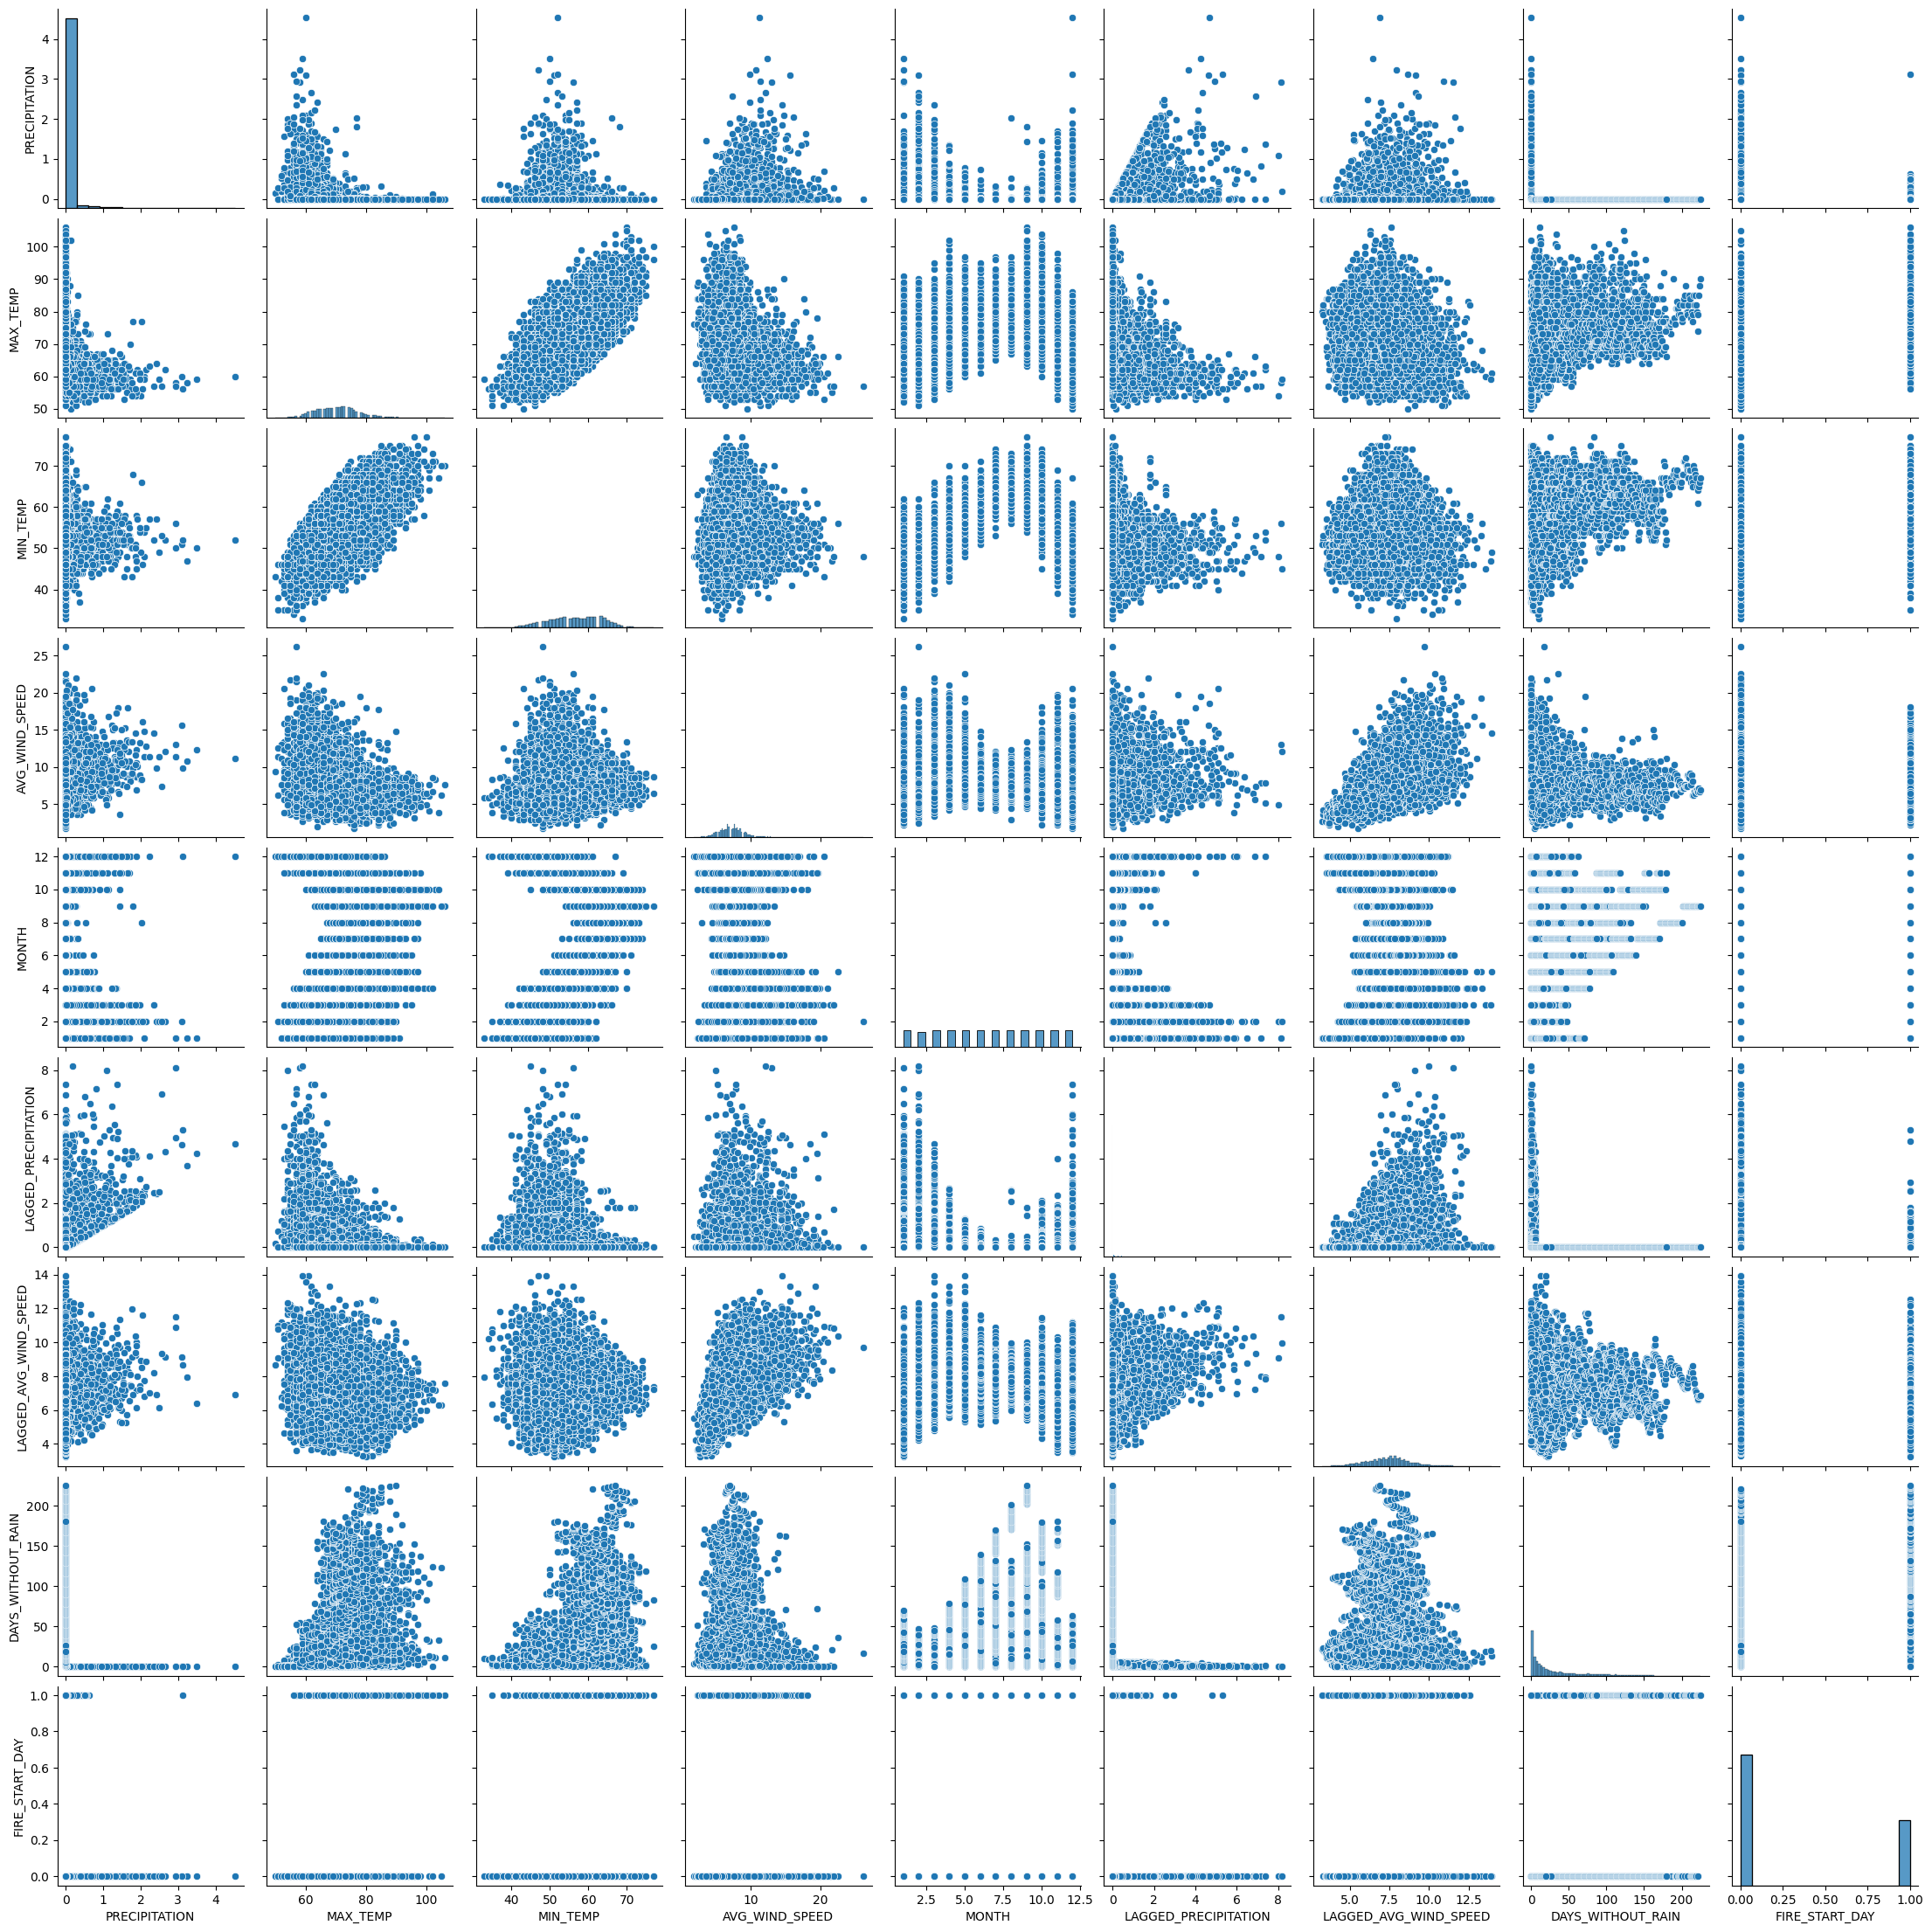

In [15]:
sns.pairplot(df[cols], kind='scatter')

In [16]:
# Investigate collinearities
# For numeric variables, 
#    - calculate Pearson corr for measure of linear correlation
#    - calculate Spearman/Kendall correlation for measure of similarly ranked values in both series
corr_pearson = df[numeric_cols].corr(method='pearson')
corr_spearman = df[numeric_cols].corr(method='spearman')
corr_kendall = df[numeric_cols].corr(method='kendall')

In [17]:
corr_pearson
#corr_spearman
#corr_kendall

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAYS_WITHOUT_RAIN
PRECIPITATION,1.000000,-0.237085,-0.112487,0.214149,0.473865,0.049551,-0.144809
MAX_TEMP,-0.237085,1.000000,0.636894,-0.165375,-0.337799,-0.077685,0.383935
MIN_TEMP,-0.112487,0.636894,1.000000,0.126739,-0.302689,0.101338,0.513130
AVG_WIND_SPEED,0.214149,-0.165375,0.126739,1.000000,0.112432,0.595673,-0.012403
LAGGED_PRECIPITATION,0.473865,-0.337799,-0.302689,0.112432,1.000000,0.172813,-0.266376
LAGGED_AVG_WIND_SPEED,0.049551,-0.077685,0.101338,0.595673,0.172813,1.000000,0.002756
DAYS_WITHOUT_RAIN,-0.144809,0.383935,0.513130,-0.012403,-0.266376,0.002756,1.000000


In [18]:
# Feature-to-target correlations
corr_pearson_full = df[numeric_cols + ['FIRE_START_DAY']].corr(method='pearson') # calculate Pearson correlation for all numeric features + target variable
corr_with_target = corr_pearson_full['FIRE_START_DAY'].drop('FIRE_START_DAY') # extract just the correlations of each feature with the target variable, excluding the self-correlation of target with itself

# Display results sorted by correlation strength
print("CORRELATION OF FEATURES WITH FIRE_START_DAY (Target Variable)")
print("="*60)
print(corr_with_target.sort_values(ascending=False)) # sort by strength of correlation with target variable
print()

# Identify strongest predictors
print("KEY INSIGHTS:")
print("="*60)
print(f"Strongest positive predictor: {corr_with_target.idxmax()} with correlation: r = {corr_with_target.max():.4f}")
print()
print(f"Strongest negative predictor: {corr_with_target.idxmin()} with correlation: r = {corr_with_target.min():.4f}")
print()

# Categorize correlations by strength
print("CORRELATION STRENGTH BREAKDOWN:")
print("="*60)

# Define thresholds for categorizing correlation strength based on common conventions
strong_pos = corr_with_target[corr_with_target > 0.3]
moderate_pos = corr_with_target[(corr_with_target > 0.1) & (corr_with_target <= 0.3)]
weak_pos = corr_with_target[(corr_with_target > 0) & (corr_with_target <= 0.1)]

# For negative correlations, we can use the same thresholds but in the negative direction
weak_neg = corr_with_target[(corr_with_target < 0) & (corr_with_target >= -0.1)]
moderate_neg = corr_with_target[(corr_with_target < -0.1) & (corr_with_target >= -0.3)]
strong_neg = corr_with_target[corr_with_target < -0.3]

# Print out the number of features in each category along with their names and correlation values for strong and moderate categories
if len(strong_pos) > 0:
    print(f"Strong positive (r > 0.3): {len(strong_pos)} features")
    for feat in strong_pos.index:
        print(f"  • {feat}: r = {strong_pos[feat]:.4f}")
    print()
if len(moderate_pos) > 0:
    print(f"Moderate positive (0.1 < r ≤ 0.3): {len(moderate_pos)} features")
    for feat in moderate_pos.index:
        print(f"  • {feat}: r = {moderate_pos[feat]:.4f}")
    print()
if len(weak_pos) > 0:
    print(f"Weak positive (0 < r ≤ 0.1): {len(weak_pos)} features")
    for feat in weak_pos.index:
        print(f"  • {feat}: r = {weak_pos[feat]:.4f}")
    print()
if len(weak_neg) > 0:
    print(f"Weak negative (-0.1 ≤ r < 0): {len(weak_neg)} features")
    for feat in weak_neg.index:
        print(f"  • {feat}: r = {weak_neg[feat]:.4f}")
    print()
if len(moderate_neg) > 0:
    print(f"Moderate negative (-0.3 ≤ r < -0.1): {len(moderate_neg)} features")
    for feat in moderate_neg.index:
        print(f"  • {feat}: r = {moderate_neg[feat]:.4f}")
    print()
if len(strong_neg) > 0:
    print(f"Strong negative (r < -0.3): {len(strong_neg)} features")
    for feat in strong_neg.index:
        print(f"  • {feat}: r = {strong_neg[feat]:.4f}")
    print()

CORRELATION OF FEATURES WITH FIRE_START_DAY (Target Variable)
MIN_TEMP                 0.468037
MAX_TEMP                 0.368320
DAYS_WITHOUT_RAIN        0.308680
LAGGED_AVG_WIND_SPEED    0.077318
AVG_WIND_SPEED           0.031216
PRECIPITATION           -0.115607
LAGGED_PRECIPITATION    -0.214150
Name: FIRE_START_DAY, dtype: float64

KEY INSIGHTS:
Strongest positive predictor: MIN_TEMP with correlation: r = 0.4680

Strongest negative predictor: LAGGED_PRECIPITATION with correlation: r = -0.2141

CORRELATION STRENGTH BREAKDOWN:
Strong positive (r > 0.3): 3 features
  • MAX_TEMP: r = 0.3683
  • MIN_TEMP: r = 0.4680
  • DAYS_WITHOUT_RAIN: r = 0.3087

Weak positive (0 < r ≤ 0.1): 2 features
  • AVG_WIND_SPEED: r = 0.0312
  • LAGGED_AVG_WIND_SPEED: r = 0.0773

Moderate negative (-0.3 ≤ r < -0.1): 2 features
  • PRECIPITATION: r = -0.1156
  • LAGGED_PRECIPITATION: r = -0.2141



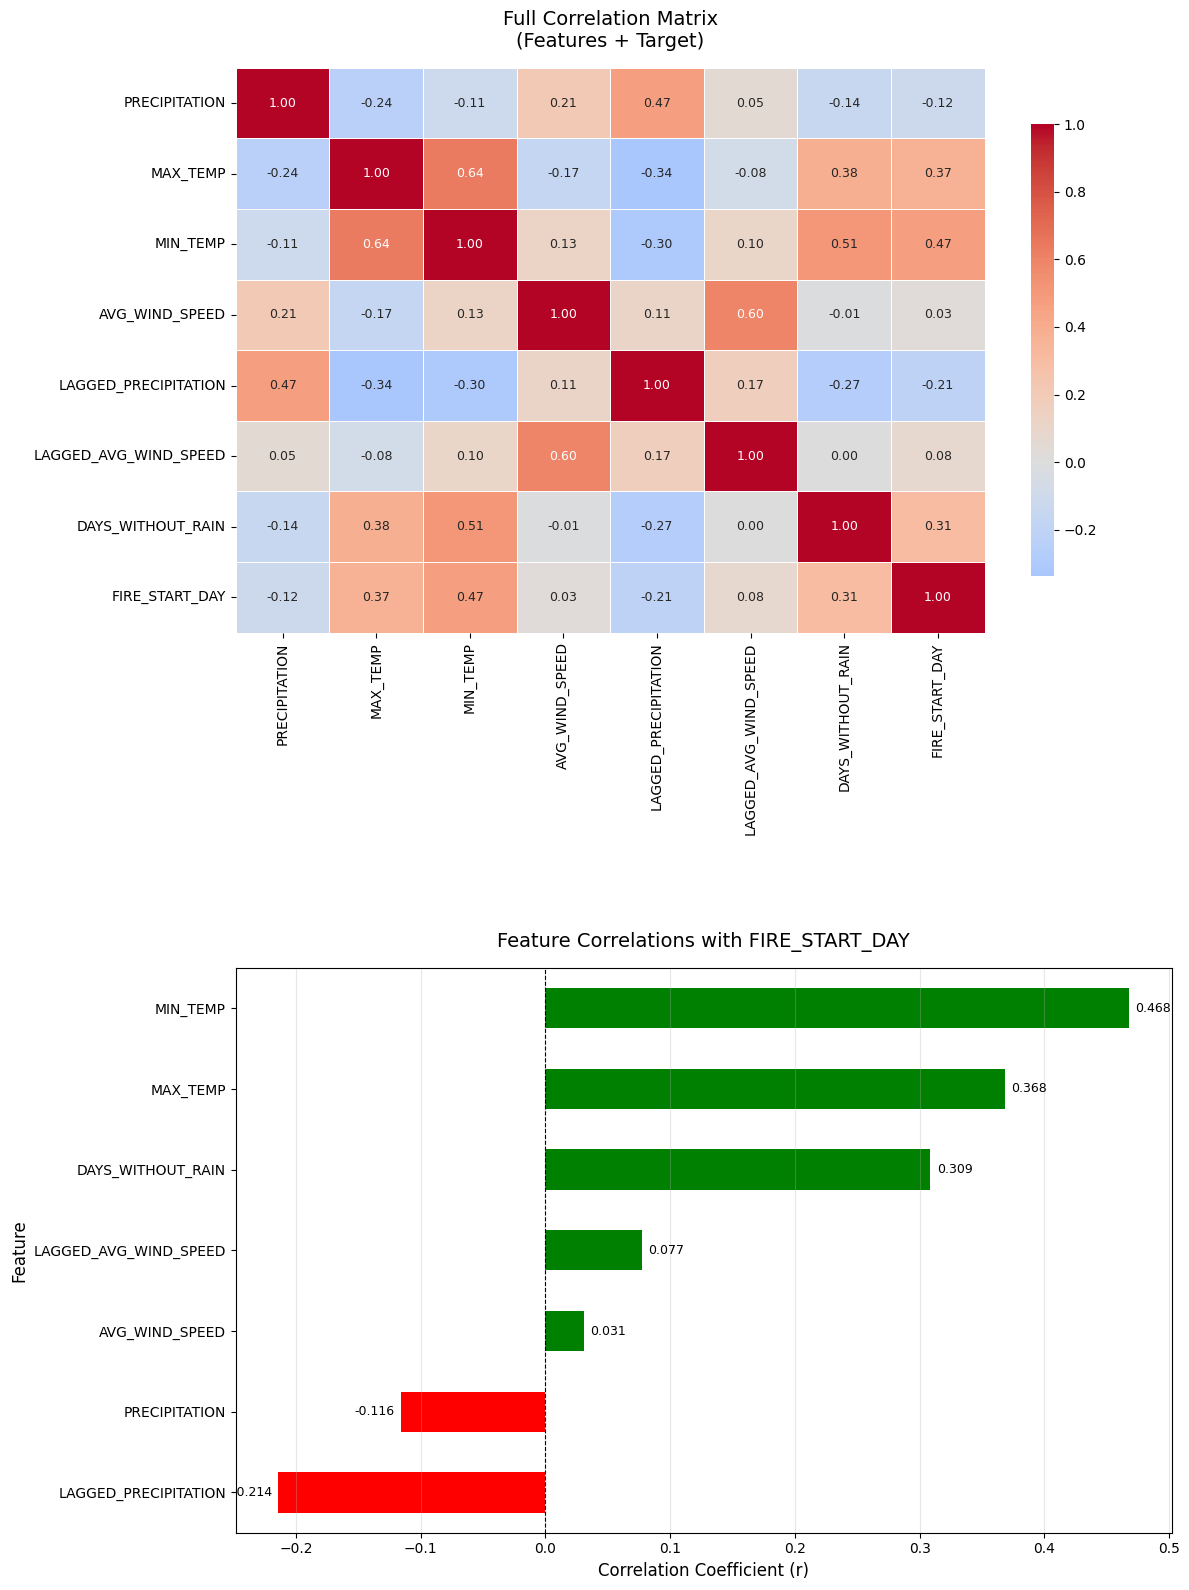

In [19]:
# Create figure with two subplots - STACKED VERTICALLY
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Top: Full correlation matrix (features + target)
sns.heatmap(corr_pearson_full, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=False,
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 9},
            ax=axes[0])
axes[0].set_title('Full Correlation Matrix\n(Features + Target)', fontsize=14, pad=15)

# Bottom: Bar plot of feature-target correlations
corr_sorted = corr_with_target.sort_values()
colors = ['red' if x < 0 else 'green' for x in corr_sorted]
corr_sorted.plot(kind='barh', color=colors, ax=axes[1])
axes[1].set_xlabel('Correlation Coefficient (r)', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)
axes[1].set_title('Feature Correlations with FIRE_START_DAY', fontsize=14, pad=15)
axes[1].axvline(x=0, color='black', linewidth=0.8, linestyle='--')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels to bars for clarity
for i, (idx, val) in enumerate(corr_sorted.items()):
    axes[1].text(val + 0.005 if val >= 0 else val - 0.005, i, 
                f'{val:.3f}', va='center', 
                ha='left' if val >= 0 else 'right', fontsize=9)

plt.subplots_adjust(hspace=0.9)  # ADD THIS LINE - controls vertical space
plt.tight_layout(h_pad=7.0)
plt.show()

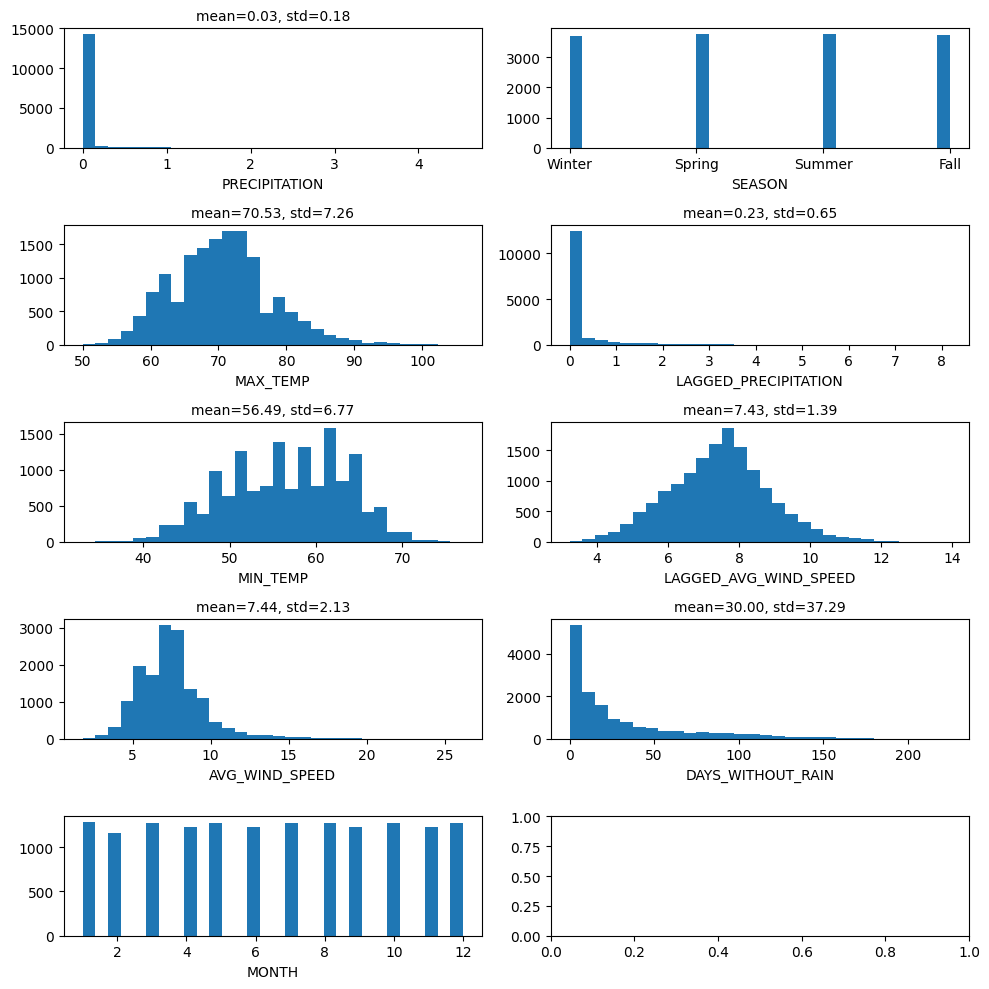

In [20]:
# Distributions
rows = math.ceil(len(feature_cols)/2)
fig, axs = plt.subplots(rows, 2, figsize=(10,10))
for i, f in enumerate(feature_cols):
    row, col = i%rows, 0 if i<rows else 1
    axs[row, col].hist(df[f], bins=30)
    axs[row, col].set_xlabel(f'{f}')
    if f not in ['SEASON', 'MONTH']:
        mean, std = df[f].mean(), df[f].std()
        axs[row, col].set_title(f"mean={mean:.2f}, std={std:.2f}", fontsize=10)
plt.tight_layout()
plt.show()

In [21]:
# Finding descriptive statistics to ascertain if any variables need to be log transformed
df.describe()

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,DAYS_WITHOUT_RAIN
count,14987.000000,14987.000000,14987.000000,14976.000000,14988.000000,14987.000000,14976.000000,14988.000000,14988.000000,14988.000000,14988.000000,14988.000000
mean,0.032315,70.534997,56.494095,7.435098,2004.016813,14.040902,0.107019,6.518281,0.226188,7.434198,182.992994,30.002268
std,0.179544,7.263447,6.767685,2.129985,11.843342,5.995327,0.035630,3.451037,0.648705,1.387849,105.523627,37.293295
min,0.000000,50.000000,33.000000,1.790000,1984.000000,2.000000,0.023553,1.000000,0.000000,3.227143,1.000000,0.000000
25%,0.000000,65.000000,51.000000,6.040000,1994.000000,10.000000,0.085238,4.000000,0.000000,6.518571,92.000000,4.000000
50%,0.000000,70.000000,57.000000,7.160000,2004.000000,12.000000,0.102222,7.000000,0.000000,7.478571,183.000000,14.000000
75%,0.000000,75.000000,62.000000,8.500000,2014.000000,17.000000,0.120462,10.000000,0.060000,8.278571,274.000000,42.000000
max,4.530000,106.000000,77.000000,26.170000,2025.000000,41.000000,0.459123,12.000000,8.180000,13.932857,366.000000,225.000000


In [22]:
print(df.dtypes)

DATE                       object
PRECIPITATION             float64
MAX_TEMP                  float64
MIN_TEMP                  float64
AVG_WIND_SPEED            float64
FIRE_START_DAY               bool
YEAR                        int64
TEMP_RANGE                float64
WIND_TEMP_RATIO           float64
MONTH                       int64
SEASON                   category
LAGGED_PRECIPITATION      float64
LAGGED_AVG_WIND_SPEED     float64
DAY_OF_YEAR                 int64
DAYS_WITHOUT_RAIN           int64
dtype: object


In [23]:
# Missing values
df.isna().sum()

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
DAYS_WITHOUT_RAIN         0
dtype: int64

Considering we only have 1- 12 rows of 14988 rows where `avg_wind_speed`, `temp_range` and `wind_temp_ratio` are missing values, we have decided to remove these rows.

Rationale for dropping rows: Since the number of missing values is negligible compared to the size of our dataset, and we are treating each row as an independent observation, we can safely remove the rows containing missing values without affecting our analysis.

In [24]:
# Drop observations with NaN values
df = df.dropna(subset=['AVG_WIND_SPEED', 'MIN_TEMP', 'MAX_TEMP'])
df.isna().sum()

DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           0
FIRE_START_DAY           0
YEAR                     0
TEMP_RANGE               0
WIND_TEMP_RATIO          0
MONTH                    0
SEASON                   0
LAGGED_PRECIPITATION     0
LAGGED_AVG_WIND_SPEED    0
DAY_OF_YEAR              0
DAYS_WITHOUT_RAIN        0
dtype: int64

#### We will consider each row as I.I.D and not consider any time dependency between each row. We are not including the following columns: `date`, `year`, `day_of_year` in our analysis to avoid any temporal dependency between the rows, thus allowing each row to be unique.

In [25]:
warnings.filterwarnings('ignore')
# Outlier Identification + Treatment
# Options for treatment: 
#   - winsorization (set lower/upper outliers to 1%/99% -iles)
#   - remove if small percentage of the data, do nothing if not?

for f in numeric_cols:
    print(f)
    # Identify outliers using 1.5*IQR
    q1_pctile, q3_pctile = df[f].quantile(0.25), df[f].quantile(0.75)
    iqr = q3_pctile - q1_pctile
    lower, upper = q1_pctile - (1.5*iqr), q3_pctile + (1.5*iqr)
    low_outliers, high_outliers = df.loc[(df[f] < lower), :], df.loc[(df[f] > upper), :]
    pct_outliers = (len(low_outliers) + len(high_outliers))/len(df)
    print(f"pct of points outliers: {pct_outliers:.2%}")
    # Winsorize outliers
    original = df[f].copy()
    df[f] = df[f].clip(lower=df[f].quantile(0.01),
                         upper=df[f].quantile(0.99))
    changed = (original != df[f]).sum()
    pct_changed = changed / len(df)
    print(f"pct data changed by winsorization: {changed}/{len(df)} = {pct_changed:.2%}")
    print("=============")

PRECIPITATION
pct of points outliers: 9.22%
pct data changed by winsorization: 149/14976 = 0.99%
MAX_TEMP
pct of points outliers: 1.08%
pct data changed by winsorization: 237/14976 = 1.58%
MIN_TEMP
pct of points outliers: 0.01%
pct data changed by winsorization: 266/14976 = 1.78%
AVG_WIND_SPEED
pct of points outliers: 3.20%
pct data changed by winsorization: 262/14976 = 1.75%
LAGGED_PRECIPITATION
pct of points outliers: 20.47%
pct data changed by winsorization: 148/14976 = 0.99%
LAGGED_AVG_WIND_SPEED
pct of points outliers: 1.23%
pct data changed by winsorization: 299/14976 = 2.00%
DAYS_WITHOUT_RAIN
pct of points outliers: 7.39%
pct data changed by winsorization: 144/14976 = 0.96%


In [26]:
# One-hot encode season and month
# first by converting them to string type
df['SEASON'] = df['SEASON'].astype(str)
df['MONTH'] = df['MONTH'].astype(str)

df = pd.get_dummies(df, columns=['SEASON', 'MONTH'], prefix=['SEASON', 'MONTH'])
print(df.columns)

Index(['DATE', 'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
       'FIRE_START_DAY', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO',
       'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAY_OF_YEAR',
       'DAYS_WITHOUT_RAIN', 'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer',
       'SEASON_Winter', 'MONTH_1', 'MONTH_10', 'MONTH_11', 'MONTH_12',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9'],
      dtype='object')


In [27]:
df = df.drop(columns=exclude_cols)
df.columns

Index(['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
       'FIRE_START_DAY', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'DAYS_WITHOUT_RAIN', 'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer',
       'SEASON_Winter', 'MONTH_1', 'MONTH_10', 'MONTH_11', 'MONTH_12',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9'],
      dtype='object')

In [28]:
# converting all df columns to lowercase
df.columns = df.columns.str.lower()

In [29]:
df.describe()

,precipitation,max_temp,min_temp,avg_wind_speed,lagged_precipitation,lagged_avg_wind_speed,days_without_rain
count,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000
mean,0.026779,70.519164,56.504708,7.418707,0.213976,7.430643,29.805355
std,0.126273,7.114970,6.679011,2.027665,0.564975,1.360638,36.491032
min,0.000000,56.000000,41.750000,3.580000,0.000000,4.248571,0.000000
25%,0.000000,65.000000,51.000000,6.040000,0.000000,6.518571,4.000000
50%,0.000000,70.000000,57.000000,7.160000,0.000000,7.478571,14.000000
75%,0.000000,75.000000,62.000000,8.500000,0.060000,8.278571,42.000000
max,0.930000,91.000000,70.000000,14.990000,3.250000,10.874286,156.000000


# Data Shuffling and Splitting


In [30]:
# 1. creating and printing list of indices mapping to df's rows
indices = df.index.tolist()
indices

np.random.seed(0)
# 2. Shuffling indices and calling array shuffled_indices. 
shuffled_indices = np.random.permutation(indices)

In [31]:
#Printing this array
shuffled_indices

array([ 3657,  7156, 14516, ...,  9848, 10802,  2732])

In [32]:
# 3. change the ordering of the dataset based on the order in the shuffled_indices array
df = df.reindex(shuffled_indices)

In [33]:
# printing head(5) for top 5 rows to confirm they match new index in shuffled_indices
df.head(5)

,precipitation,max_temp,min_temp,avg_wind_speed,fire_start_day,lagged_precipitation,lagged_avg_wind_speed,days_without_rain,season_fall,season_spring,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
3657,0.0,66.0,53.0,5.82,False,0.0,5.974286,10,False,False,...,False,False,False,False,False,False,False,False,False,False
7156,0.0,78.0,61.0,7.83,True,0.0,8.597143,8,False,False,...,False,False,False,False,False,False,False,False,True,False
14516,0.0,70.0,65.0,6.49,False,0.0,6.614286,12,True,False,...,False,False,False,False,False,False,False,False,False,True
1948,0.0,72.0,55.0,6.04,False,0.0,7.702857,38,False,True,...,False,False,False,False,False,True,False,False,False,False
12141,0.0,75.0,54.0,5.82,False,0.0,9.490000,7,False,True,...,False,False,False,True,False,False,False,False,False,False


### Defining Outcome and Features

In [34]:
# first outcome dataframe with 'FIRE_START_DAY' and named Y. printing Y
Y = df[['fire_start_day']]
Y

,fire_start_day
3657,False
7156,True
14516,False
1948,False
12141,False
...,...
13126,False
3264,False
9848,False
10802,True


In [35]:
# feature dataframe called X with features of interest: 
temp = df.copy()
temp = temp.drop(columns=['fire_start_day'])
X = temp

### Data Splits

In [36]:
# 1. first splitting test set since train_test_split method only splits 2 sets a time
X_temporary, X_test, Y_temporary, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [37]:
# second splitting test set since train_test_split method only splits 2 sets a time
X_train, X_val, Y_train, Y_val = train_test_split(X_temporary, Y_temporary, test_size=0.25, random_state=1234)

In [38]:
# 2. printing shape of each array:X_train, X_val, X_test, Y_train, Y_val, Y_test;
print("shape of X_train:", X_train.shape)
print("shape of X_val:", X_val.shape)
print("shape of X_test:", X_test.shape)
print("shape of Y_train:", Y_train.shape)
print("shape of Y_val:", Y_val.shape)
print("shape of Y_test:", Y_test.shape)

shape of X_train: (8985, 23)
shape of X_val: (2995, 23)
shape of X_test: (2996, 23)
shape of Y_train: (8985, 1)
shape of Y_val: (2995, 1)
shape of Y_test: (2996, 1)


### Standardization only on X_train data

In [39]:
X_train.columns

Index(['precipitation', 'max_temp', 'min_temp', 'avg_wind_speed',
       'lagged_precipitation', 'lagged_avg_wind_speed', 'days_without_rain',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'month_1', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9'],
      dtype='object')

In [40]:
numeric_cols_lower = [i.lower() for i in numeric_cols]

# Creating copies to avoid any warning later
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

# initializing the scaler
scaler = StandardScaler()


# fitting on train and transforming train, val and test to avoid data leakage
X_train_std[numeric_cols_lower] = scaler.fit_transform(X_train[numeric_cols_lower])
X_val_std[numeric_cols_lower] = scaler.transform(X_val[numeric_cols_lower])
X_test_std[numeric_cols_lower] = scaler.transform(X_test[numeric_cols_lower])

In [41]:
X_train_std.head()

,precipitation,max_temp,min_temp,avg_wind_speed,lagged_precipitation,lagged_avg_wind_speed,days_without_rain,season_fall,season_spring,season_summer,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
8767,-0.207862,0.626375,0.215557,-0.794694,-0.376837,-1.145229,-0.464714,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4149,-0.207862,-0.648302,-0.236258,0.526579,-0.376837,0.191252,-0.164044,False,True,False,...,False,False,False,False,False,True,False,False,False,False
8502,-0.207862,-0.223409,-0.537468,1.961244,-0.376837,-0.112494,-0.382713,False,True,False,...,False,False,False,False,True,False,False,False,False,False
6298,-0.207862,-0.648302,-0.085653,0.304723,-0.376837,-0.396339,-0.546715,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4400,-0.207862,-0.789932,-0.989283,-0.134058,0.035585,0.238385,-0.765384,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Confirming that Y values are showing up as 1 and 0 for the binary classification

In [42]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

# reclassifying if Y_train from boolean to integer (1/0)
Y_train = (Y_train.astype(int))
Y_test = (Y_test.astype(int))

print(np.unique(Y_train))
print(np.unique(Y_test))

[0 1]
[0 1]


### Checking for class imbalance in Y_train

In [43]:
# counting training set and percentages
# unique values and their raw counts
labels, counts = np.unique(Y_train, return_counts=True)

# calculating percentage
percentage = (counts/len(Y_train)) *100

for label, count, percent in zip(labels, counts, percentage):
    print(f"Class {label}: {count} samples ({percent}%)")

Class 0: 6015 samples (66.9449081803005%)
Class 1: 2970 samples (33.0550918196995%)


### Baseline Model (Alvaro)

In [92]:
# baseline model
values, counts = np.unique(Y_train, return_counts=True)
baseline_model = values[counts.argmax()]

# baseline probability = majority class proportion
p = counts.max() / counts.sum()

# binary cross-entropy loss
def binary_cross_entropy(y_true, p):
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

# baseline model accuracies for train and val data
baseline_train_acc = np.mean(Y_train == baseline_model)
baseline_val_acc = np.mean(Y_val == baseline_model)
train_loss = binary_cross_entropy(Y_train, p)
val_loss = binary_cross_entropy(Y_val, p)

# print majority class and accuracies
print(f"Majority class: {baseline_model}")
print(f"Baseline train accuracy: {baseline_train_acc:.4f} | loss: {train_loss:.4f}")
print(f"Baseline val accuracy:   {baseline_val_acc:.4f} | loss: {val_loss:.4f}")

Majority class: 0
Baseline train accuracy: 0.6694 | loss: 0.8737
Baseline val accuracy:   0.6658 | loss: 0.8711


### Building Logistic Regression

In [44]:
def build_model(hp):
  """Build a TF linear regression model using Keras.

  Args:
    #TODO NEED TO ADD THIS
  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  num_features = X_train_std.shape[1]
    
  # providing a range of learning rates for the later search history and tuner next
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001])
  hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    
  # Build a model using keras.Sequential. We want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim = 1 as we want 1 layer
      input_shape=(num_features,),
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),  
      bias_initializer=tf.zeros,    # initialize bias to 0
  ))
 

  # Compile the model with binary_accuracy for graphing
  model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer =tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
        metrics=['binary_accuracy']
  )
    
  return model

In [45]:
# initializing the tuner where function of build_model function is being passed
# it will build and tune the model through the liearning rates
tuner = kt.Hyperband(
    hypermodel=build_model, # passing that function from above telling tuner how to build the model_tf
    objective='val_binary_accuracy', # matches the metric in build_model
    max_epochs=100,
    factor=3,
    directory='tuning_dir',
    project_name='lr_batch_tuner',
    overwrite=True
)
# callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner search with max
tuner.search(X_train_std, Y_train, validation_data=(X_val_std, Y_val), callbacks = [stop_early]) 

# provides the best optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 12 Complete [00h 00m 01s]
val_binary_accuracy: 0.6580968499183655

Best val_binary_accuracy So Far: 0.7686143517494202
Total elapsed time: 00h 00m 09s


In [46]:
print(best_hps.values)

{'learning_rate': 0.01, 'batch_size': 64, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [47]:
## Finding the best epoch 
# Now using the best_hps to build temporary model with the optimal hyperparameters identified above and train model
best_batch = best_hps.get('batch_size')

# building model with best settings
model_tf = tuner.hypermodel.build(best_hps)

# retraining on higher epochs to find peak performance
history = model_tf.fit(X_train_std, Y_train, 
                         epochs=100, 
                         batch_size=best_batch, #using tuned batch_size from best_hps
                         validation_data=(X_val_std, Y_val), 
                         class_weight={0: 1, 1: 2}, # Adjusting for the 67/33 split
                         verbose = 0
                        )

# using val_binary_accuracy to find best epoch
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 32


In [48]:
# Show learned model with weights and biases from 
w = model_tf.layers[0].get_weights()[0]  # the weights matrix
b = model_tf.layers[0].get_weights()[1]  # the bias vector

print('First Bias:', b[0])
print('First 4 Weights', w[:4].flatten())

# 3. loss at the final epoch
train_loss = history.history['loss'][-1]
train_binary_accuracy = history.history['binary_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_binary_accuracy = history.history['val_binary_accuracy'][-1]

print('Final train loss:', train_loss)
print('Final validation loss:', val_loss)
print('Final train_accuracy:', train_binary_accuracy)
print("Final_val_accuracy:", val_binary_accuracy)

First Bias: -0.35141873
First 4 Weights [-0.30741808  0.38194764  0.3748468  -0.06970201]
Final train loss: 0.6701889634132385
Final validation loss: 0.5033658146858215
Final train_accuracy: 0.7518085837364197
Final_val_accuracy: 0.7585976719856262


In [49]:
# 4. percentage difference between the losses observed on the training and validation datasets
percentage_diff = ((train_loss - val_loss)/train_loss)*100
print(" percentage difference between the losses observed on the training and validation datasets:",percentage_diff )

 percentage difference between the losses observed on the training and validation datasets: 24.89195702027009


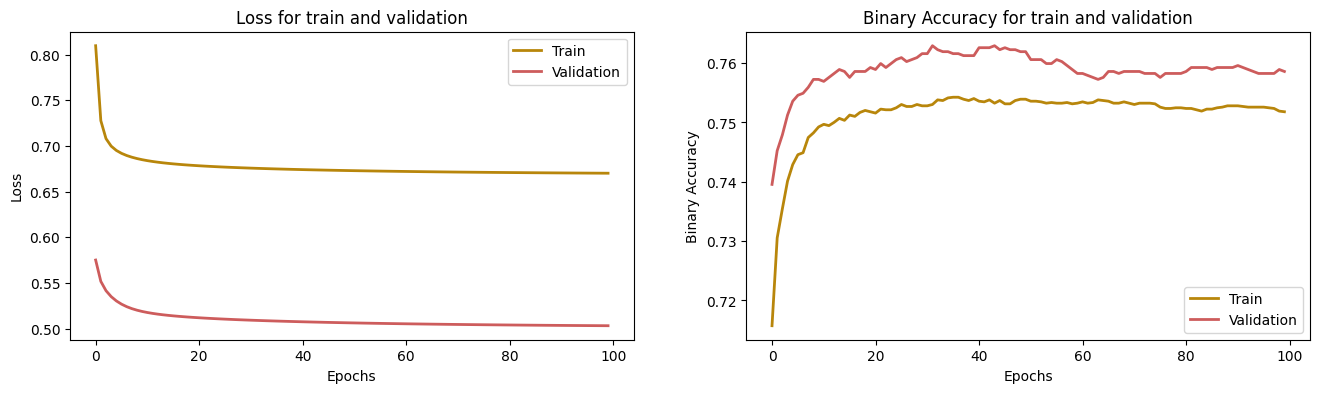

In [50]:
# grab history
history = history.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_ylabel('Loss')
ax.set_title('Loss for train and validation');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_ylabel('Binary Accuracy')
ax.set_title('Binary Accuracy for train and validation');

### Model evaluation and generalization

In [51]:
### print accuracy for test based on running the trained model on the test data 
# (the model outputs probabilities)
# getting predicted probabilities using model_tf tuned above
y_test_pred_tf = model_tf.predict(x=X_test_std)
y_train_pred_tf = model_tf.predict(x = X_train_std)

# set predicted label based on highest probability compare across columns (so asking for each row, we are looking
# the column index of the max value).
test_labels =  np.argmax(y_test_pred_tf, axis=1)
train_labels =  np.argmax(y_train_pred_tf, axis=1)

# printing accuracies
train_accuracy = np.mean(train_labels == Y_train)
test_accuracy  = np.mean(test_labels == Y_test)

print("Aggregate train accuracy:", train_accuracy)
print("Aggregate test accuracy:", test_accuracy)
print("Gap between aggregate test and train accuracy", test_accuracy - train_accuracy)



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
Aggregate train accuracy: 0.669449081803005
Aggregate test accuracy: 0.6662216288384513
Gap between aggregate test and train accuracy -0.003227452964553734


In [52]:
## evaluating the model
train_results = model_tf.evaluate(X_train_std, Y_train, verbose=0)
test_results = model_tf.evaluate(X_test_std, Y_test, verbose=0)

print("Train loss:", train_results[0])
print("Test loss:", test_results[0])
print("Gap between train and test loss:", test_results[0] - train_results[0])

Train loss: 0.5078343749046326
Test loss: 0.49768757820129395
Gap between train and test loss: -0.010146796703338623


## QUESTION: Need to confirm we have the right y_test_pred

### Metrics

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


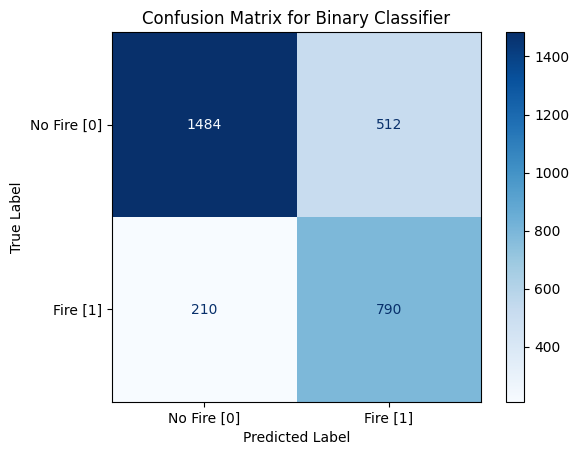

In [53]:
### print accuracy for test
y_test_prob = model_tf.predict(X_test_std).ravel()

# set predicted label based on threshold of 0.5
y_test_pred = (y_test_prob > 0.5).astype(int)

# displaying the Confusion Matrix on the test data 
disp = ConfusionMatrixDisplay.from_predictions(Y_test, y_test_pred, cmap=plt.cm.Blues,
                                              display_labels=["No Fire [0]", "Fire [1]"])

disp.ax_.set_title("Confusion Matrix for Binary Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the confusion matrix plot
plt.show()

In [54]:
# the precision and recall
from sklearn.metrics import classification_report
print(classification_report(
    y_true = Y_test, # this is the actual ground truth in 0s and 1s
    y_pred = y_test_pred,  # labels predicted by model_tf
    target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.88      0.74      0.80      1996
        Fire       0.61      0.79      0.69      1000

    accuracy                           0.76      2996
   macro avg       0.74      0.77      0.75      2996
weighted avg       0.79      0.76      0.76      2996



### Learnings from Logistic model: Considering logistic regression model is giving accuracy of 0.76 or 76% which is better than the baseline guessing of 67% (no fire), so 9% better. The model is catching 0.79 or 79% of all fires (fire recall), which we would like to explore as getting better with our next two models. The fire precision (61%) means that 39% are false alarms, when it was not a fire. Again, we would like to make these better with are more advanced models.

**Notes/Questions**
- How do we handle time dependency?

Logistic regression/gradient descent allows for dependence between observations. Will need to consider for train test split (ie use the more recent observations as the test set)

- What to do with time-related features for logistic regression?

Some seem relevant - ie season. But don't think about autocorrelations in observations re: the outcome variable. Think about every sample as independent and then for the time-related features, include them if you thinkn they inform risk for the observation on that given day

- What to do about collinearities? Do we need to handle?

Even if have a perfectly collinear feature, thats still mechanically fine for gradient descent. Gradient descent can handle anything mechanically.

But for the best performance, get rid of collinear features or combine them (add or multiply)

For fitting a logistic regression model, one COULD try every combo of features, fit model, and see which has the best AIC/BIC, but that may be beyond scope. 